Jupyter notebook to generate the goal points

In [16]:
import cv2
import numpy as np
import os
import copy
import sys
import math
import git
import torch
import matplotlib.pyplot as plt
import time

In [17]:
repo = git.Repo('.', search_parent_directories=True)
BASE_DIR = repo.working_tree_dir
sys.path.append(BASE_DIR)

import model.datasets.argoverse.dataset as dataset
import model.datasets.argoverse.dataset_utils as dataset_utils
import model.datasets.argoverse.goal_points_functions as goal_points_functions  
import model.datasets.argoverse.map_functions as map_functions                                            

from argoverse.map_representation.map_api import ArgoverseMap

avm = ArgoverseMap()

In [18]:
# Load files

dataset_path = "data/datasets/argoverse/motion-forecasting/"
split = "train"
split_folder = BASE_DIR + "/" + dataset_path + split
data_folder = BASE_DIR + "/" + dataset_path + split + "/data/"
data_images_folder = BASE_DIR + "/" + dataset_path + split + "/data_images"
# data_images_folder = BASE_DIR + "/" + dataset_path + split + "/data_images_200mx200m"

files, num_files = dataset_utils.load_list_from_folder(data_folder)

file_id_list = []
root_file_name = None
for file_name in files:
    if not root_file_name:
        root_file_name = os.path.dirname(os.path.abspath(file_name))
    file_id = int(os.path.normpath(file_name).split('/')[-1].split('.')[0])
    file_id_list.append(file_id)
file_id_list.sort()
print("Num files: ", num_files)

Num files:  205942


In [19]:
file_id_list[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

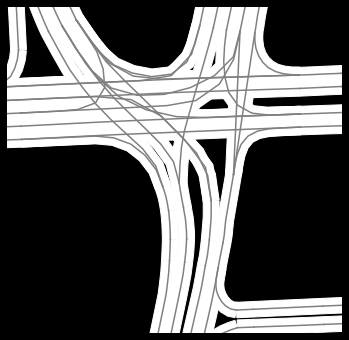

In [20]:
# Generate a rasterized representation of the map 
# (Just to illustrate the driveable area, not required in our algorithm)

file_id = "4" # Override this variable to compute a different local map
dist_around = 40 # m around the ego-vehicle
dist_rasterized_map = [-dist_around, dist_around, -dist_around, dist_around]  

path = os.path.join(root_file_name,str(file_id)+".csv")
data = dataset_utils.read_file(path) 

obs_origin = 20
origin_pos, city_name = dataset_utils.get_origin_and_city(data,obs_origin)

map_functions.map_generator(file_id, 
                            origin_pos,
                            dist_rasterized_map,
                            avm,
                            city_name,
                            centerlines_colour="gray",
                            show=False,
                            root_folder=data_images_folder)

In [21]:
# Goal points hyperparameters

show_pred_gt = True
show = True
save_fig = True
change_img_bg = False
num_initial_samples = 1000
pred_seconds = 3 # [seconds] To compute the goal points 
                 #           until pred_seconds ahead (assuming constant velocity)
NUM_GOAL_POINTS = 32
MAX_CLUSTERS = 6 # Maximum number of modes (multimodality)
MULTIMODAL = True 

goal_points_folder = split_folder + "/goal_points_test"

In [22]:
# 0. Load image

filename = data_images_folder + "/" + str(file_id) + ".png"
real_world_offset = dist_around

img = cv2.imread(filename)
img = cv2.resize(img, dsize=(600,600))
height, width = img.shape[:2]
img_size = height
scale_x = scale_y = float(height/(2*real_world_offset))

cx = int(width/2)
cy = int(height/2)
car_px = (cy,cx)

In [23]:
# 1. Get past observations

obs_len = 20
pred_len = 30
seq_len = obs_len + pred_len
skip = 1

frames = np.unique(data[:, 0]).tolist() 
frame_data = []
for frame in frames:
    frame_data.append(data[frame == data[:, 0], :]) # save info for each frame

num_sequences = int(math.ceil((len(frames) - seq_len + 1) / skip))
idx = 0

num_objs_considered, _non_linear_obj, curr_loss_mask, curr_seq, \
curr_seq_rel, id_frame_list, object_class_list, city_id, map_origin = \
    dataset.process_window_sequence(idx, frame_data, frames, \
                                    obs_len, pred_len, file_id, split, obs_origin)

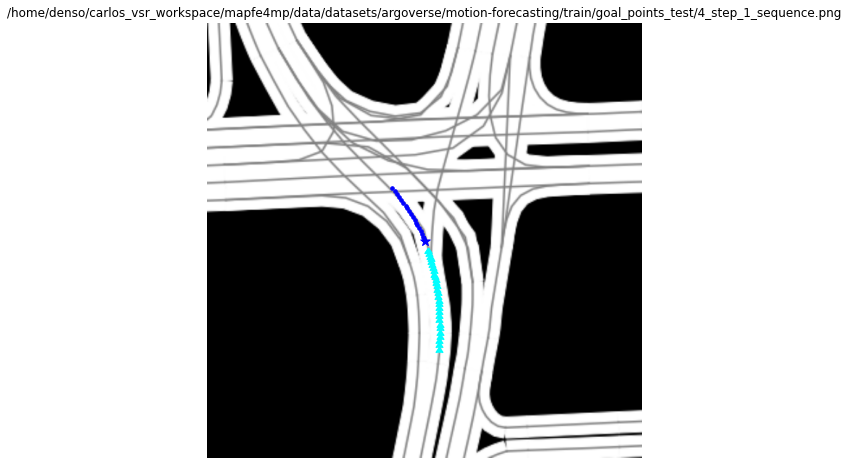

In [24]:
# 2. Plot AGENT trajectory

if not os.path.exists(goal_points_folder):
    print("Create goal points folder: ", goal_points_folder)
    os.makedirs(goal_points_folder) # makedirs creates intermediate folders

seq_id = file_id

agent_index = np.where(object_class_list == 1)[0].item()

agent_seq = curr_seq[agent_index,:,:].transpose() # Whole sequence

agent_seq_global = agent_seq + origin_pos # abs (hdmap coordinates)
agent_seq_global = torch.from_numpy(agent_seq_global)

# px = pixels
agent_px_points = goal_points_functions.transform_real_world2px(agent_seq_global, origin_pos, real_world_offset, img_size)
agent_px_x, agent_px_y = agent_px_points[:,0], agent_px_points[:,1] # TODO: Refactorize
filename = goal_points_folder + "/" + seq_id + "_step_1_sequence.png"

goal_points_functions.plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin, 
                                    show_pred_gt=show_pred_gt, save_fig=save_fig, show=show, change_bg=change_img_bg)

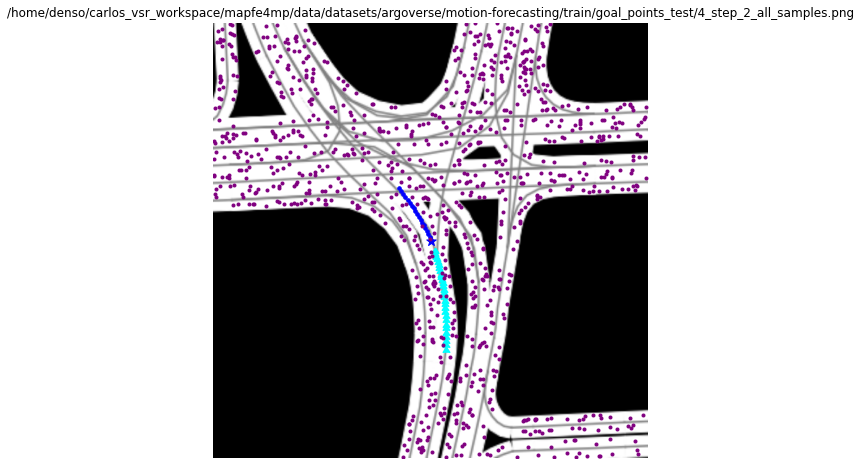

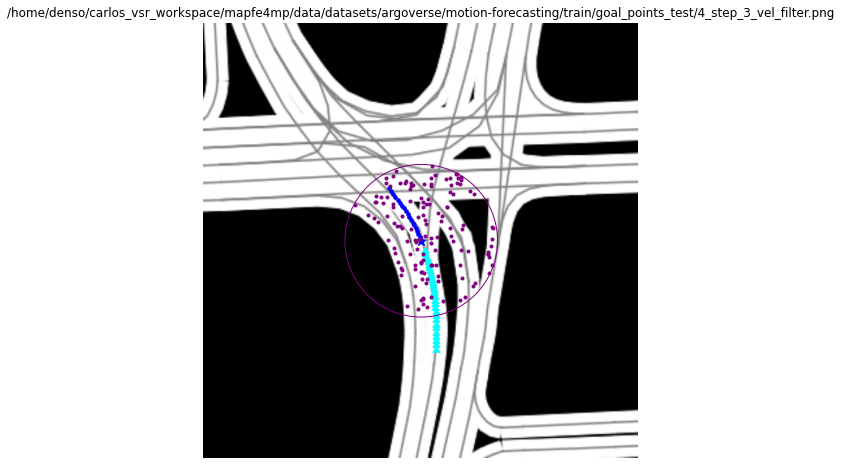

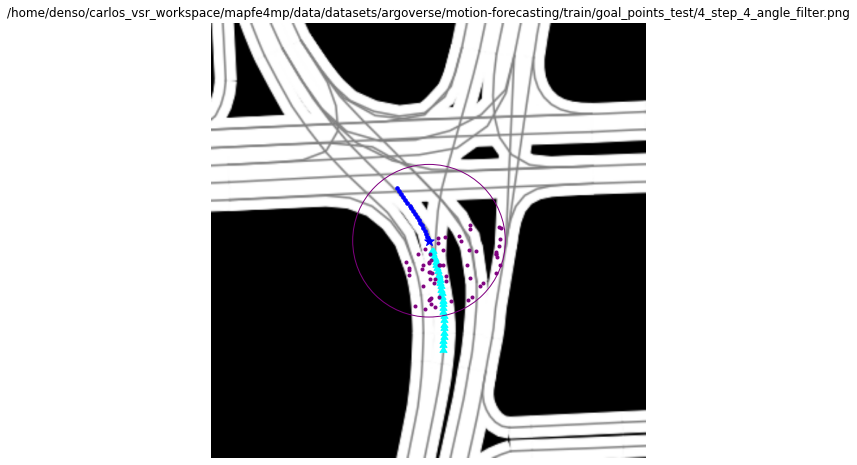

Without filtering: vel 4.67952040676095, yaw -1.151234838207861


In [25]:
# 3. Get feasible area points (N samples)

# 3.0. (Optional) Observe random sampling in the whole feasible area

rad = 1000 # meters. Cause we want to observe all points around the AGENT

fe_y, fe_x = goal_points_functions.get_points(img, car_px, scale_x, rad=10000, color=255, N=num_initial_samples, 
                        sample_car=True, max_samples=None) # return rows, columns
filename = goal_points_folder + "/" + seq_id + "_step_2_all_samples.png"

goal_points_functions.plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin,
                                    goals_px_x=fe_x, goals_px_y=fe_y,
                                    show_pred_gt=show_pred_gt, save_fig=save_fig, show=show, change_bg=change_img_bg)

# 3.1. Filter using AGENT estimated velocity in the last observation frame

agent_obs_seq_global = agent_seq_global[:obs_origin,:]
mean_vel = goal_points_functions.get_agent_velocity(torch.transpose(agent_obs_seq_global,0,1))
radius = mean_vel * pred_seconds
radius_px = radius * scale_x	

fe_y, fe_x = goal_points_functions.get_points(img, car_px, scale_x, rad=radius_px, color=255, N=1024, 
                            sample_car=True, max_samples=None) # return rows, columns

filename = goal_points_folder + "/" + seq_id + "_step_3_vel_filter.png"

goal_points_functions.plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin,
                                    goals_px_x=fe_x, goals_px_y=fe_y, radius=radius_px, 
                                    show_pred_gt=show_pred_gt, save_fig=save_fig, show=show, change_bg=change_img_bg)

# 3.2. Filter using AGENT estimated orientation (yaw) in the last observation frame

mean_yaw = goal_points_functions.get_agent_yaw(torch.transpose(agent_obs_seq_global,0,1)) # radians

if mean_yaw >= 0.0:
    angle = math.pi/2 - mean_yaw
elif mean_yaw < 0.0:
    angle = -(math.pi / 2 + (math.pi - abs(mean_yaw)))

c, s = np.cos(angle), np.sin(angle)
R = np.array([[c,-s], [s, c]])

fe_x_trans = fe_x - cx # get px w.r.t. the center of the image to be rotated
fe_y_trans = fe_y - cy

close_pts = np.hstack((fe_x_trans.reshape(-1,1),fe_y_trans.reshape(-1,1)))
close_pts_rotated = np.matmul(close_pts,R).astype(np.int32)

fe_x_rot = close_pts_rotated[:,0] + cx
fe_y_rot = close_pts_rotated[:,1] + cy

filtered_fe_x = fe_x[np.where(fe_y_rot < cy)[0]]
filtered_fe_y = fe_y[np.where(fe_y_rot < cy)[0]]

filename = goal_points_folder + "/" + seq_id + "_step_4_angle_filter.png"

goal_points_functions.plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin,
                                    goals_px_x=filtered_fe_x, goals_px_y=filtered_fe_y, radius=radius_px, 
                                    show_pred_gt=show_pred_gt, save_fig=save_fig, show=show, change_bg=change_img_bg)  

print(f"Without filtering: vel {mean_vel}, yaw {mean_yaw}")


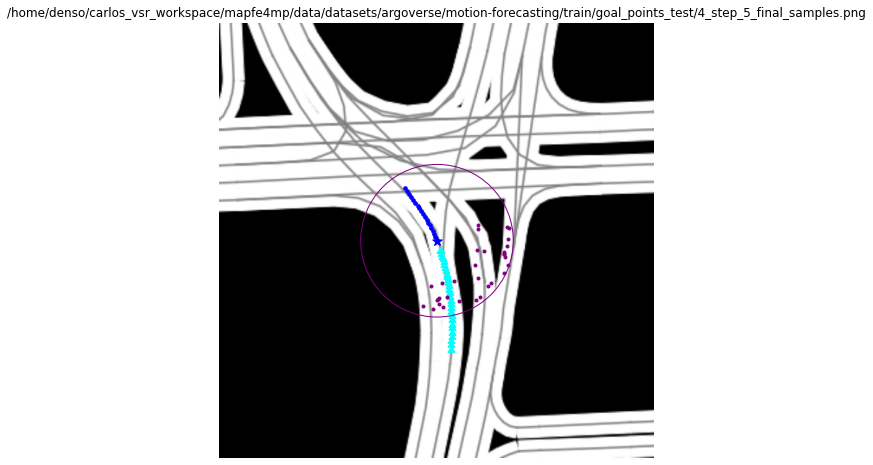

In [26]:
# 4. Get furthest N samples (closest the the hypothetical radius)

dist = []
for i in range(len(filtered_fe_x)):
    d = math.sqrt(pow(filtered_fe_x[i] - car_px[0],2) + pow(filtered_fe_y[i] - car_px[1],2))
    dist.append(d)

dist = np.array(dist)

furthest_indeces = np.argsort(dist)
if len(furthest_indeces) > NUM_GOAL_POINTS:
    furthest_indeces = np.argsort(dist)[-NUM_GOAL_POINTS:]

final_samples_x, final_samples_y = filtered_fe_x[furthest_indeces], filtered_fe_y[furthest_indeces]

try:
    diff_points = NUM_GOAL_POINTS - len(final_samples_x)
    final_samples_x = np.hstack((final_samples_x, final_samples_x[0]+0.2 * np.random.randn(diff_points)))
    final_samples_y = np.hstack((final_samples_y, final_samples_y[0]+0.2 * np.random.randn(diff_points)))
except:
    final_samples_x = cx + scale_x*np.random.randn(NUM_GOAL_POINTS)
    final_samples_y = cy + scale_y*np.random.randn(NUM_GOAL_POINTS)

filename = goal_points_folder + "/" + seq_id + "_step_5_final_samples.png"

goal_points_functions.plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin, 
                                    goals_px_x=final_samples_x, goals_px_y=final_samples_y, radius=radius_px,
                                    show_pred_gt=show_pred_gt, save_fig=save_fig, show=show, change_bg=change_img_bg)

if len(final_samples_x) != NUM_GOAL_POINTS:
    print(f"Final samples does not match with {NUM_GOAL_POINTS} required samples")
    goal_points_functions.plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin,
                                        goals_px_x=final_samples_x, goals_px_y=final_samples_y, radius=radius_px,
                                        show_pred_gt=show_pred_gt, save_fig=save_fig, show=show, change_bg=change_img_bg)

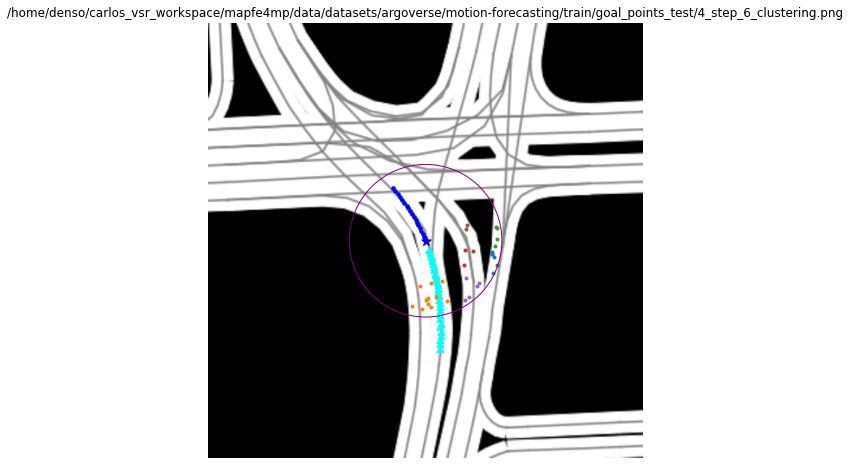

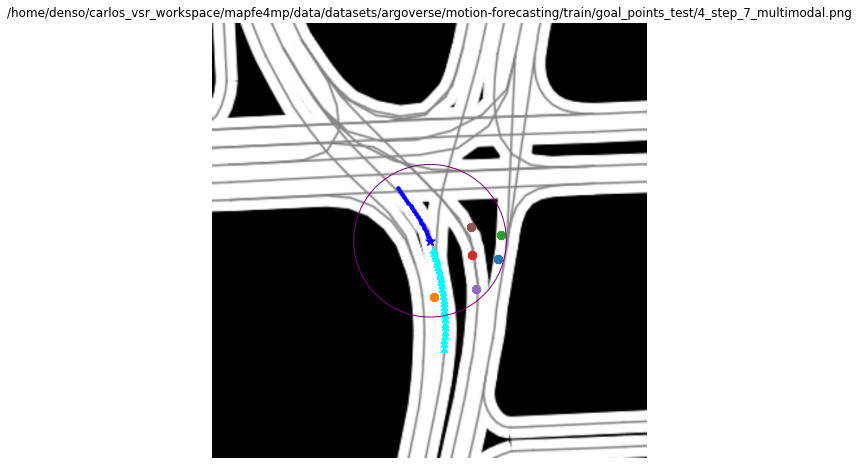

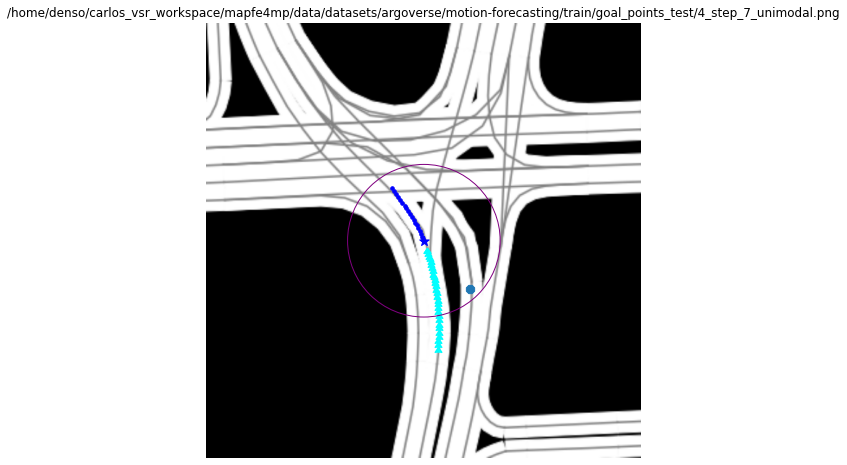

In [27]:
# 5. Clustering

final_samples = np.hstack((final_samples_x.reshape(-1,1),final_samples_y.reshape(-1,1)))
final_samples.shape

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

# Initialize the class object

kmeans = KMeans(n_clusters = MAX_CLUSTERS)
 
# Predict the labels of clusters

label = kmeans.fit_predict(final_samples)

# Getting unique labels
 
u_labels = np.unique(label)

filename = goal_points_folder + "/" + seq_id + "_step_6_clustering.png"
goal_points_functions.plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin,
                                    goals_px_x=final_samples_x, goals_px_y=final_samples_y, label=label, radius=radius_px,
                                    show_pred_gt=show_pred_gt, save_fig=save_fig, show=show, change_bg=change_img_bg)

# Final clusters

aux = torch.zeros((MAX_CLUSTERS,2))
cont_goals = torch.zeros((MAX_CLUSTERS))

for i in range(final_samples.shape[0]):
    aux[label[i],0] += final_samples[i,0]
    aux[label[i],1] += final_samples[i,1]
    cont_goals[label[i]] += 1 # Num goals per cluster
aux = torch.div(aux,cont_goals.reshape(MAX_CLUSTERS,1))
label = torch.arange(MAX_CLUSTERS)

filename = goal_points_folder + "/" + seq_id + "_step_7_multimodal.png"
goal_points_functions.plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin,
                                    goals_px_x=aux[:,0], goals_px_y=aux[:,1], label=label, radius=radius_px,
                                    show_pred_gt=show_pred_gt, save_fig=save_fig, show=show, change_bg=change_img_bg, final_clusters=True)

rng = np.random.default_rng()

# TODO: Select unimodal goal as the easiest or most coherent (in most cases, the goal which is in front of the vehicle)

single_mode = rng.choice(label, size=1)

filename = goal_points_folder + "/" + seq_id + "_step_7_unimodal.png"
goal_points_functions.plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin,
                                    goals_px_x=aux[single_mode,0], goals_px_y=aux[single_mode,1], label=single_mode, radius=radius_px, 
                                    show_pred_gt=show_pred_gt, save_fig=save_fig, show=show, change_bg=change_img_bg, final_clusters=True)

In [28]:
# 6. Transform pixels to real-world coordinates

final_samples_px = np.hstack((aux[:,1].reshape(-1,1), aux[:,0].reshape(-1,1))) # rows (y), columns (x)
rw_points = goal_points_functions.transform_px2real_world(final_samples_px, origin_pos, real_world_offset, img_size)

In [29]:
# 7. Compute error with respect to groundtruth endpoint

end_point_gt_map = agent_seq[-1,:]

closest_gp_dist = 50000

for rw_point in rw_points:
    dist = np.linalg.norm(rw_point - end_point_gt_map)

    if dist < closest_gp_dist:
        closest_gp_dist = dist

print("Closest dist: ", closest_gp_dist)

Closest dist:  4026.9969210362424


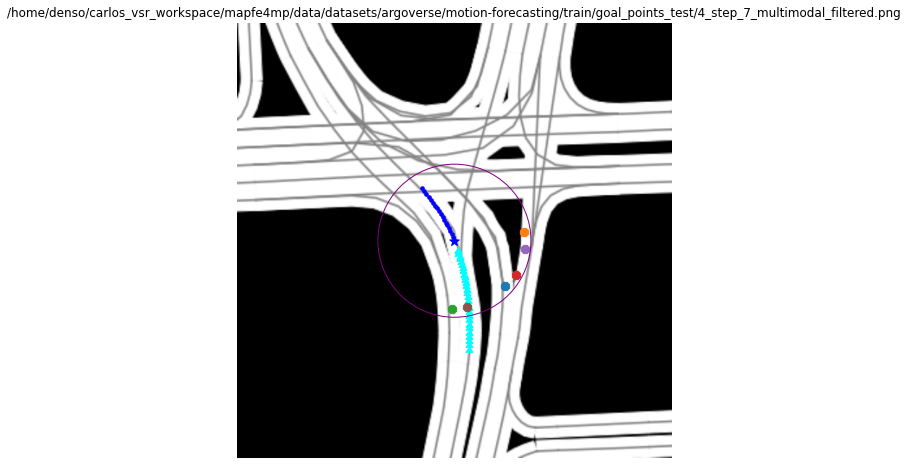

With filtering: vel 4.6937247282038985, yaw -1.1484045676877572


In [30]:
# 8. Apply Savitzky–Golay filter

from scipy.signal import savgol_filter

agent_seq_tensor = torch.from_numpy(agent_seq)
x = agent_seq_tensor[:obs_len,0]
y = agent_seq_tensor[:obs_len,1]

xy = torch.vstack((x, y))
xy_f = torch.from_numpy(savgol_filter(xy, window_length=5, polyorder=3, axis=1))

x_f = xy_f[0, :]
y_f = xy_f[1, :]

# plt.plot(x, y, ':o', x_f, y_f, '.-')
# plt.show()

# Velocity

agent_obs_seq_global_f = torch.hstack([x_f.reshape(-1,1),y_f.reshape(-1,1)]) + torch.FloatTensor(origin_pos)
mean_vel = goal_points_functions.get_agent_velocity(torch.transpose(agent_obs_seq_global_f,0,1))
radius = mean_vel * pred_seconds
radius_px = radius * scale_x	

fe_y, fe_x = goal_points_functions.get_points(img, car_px, scale_x, rad=radius_px, color=255, N=1024, 
                            sample_car=True, max_samples=None) # return rows, columns

# Yaw

mean_yaw = goal_points_functions.get_agent_yaw(torch.transpose(agent_obs_seq_global_f,0,1)) # radians

if mean_yaw >= 0.0:
    angle = math.pi/2 - mean_yaw
elif mean_yaw < 0.0:
    angle = -(math.pi / 2 + (math.pi - abs(mean_yaw)))

c, s = np.cos(angle), np.sin(angle)
R = np.array([[c,-s], [s, c]])

fe_x_trans = fe_x - cx # get px w.r.t. the center of the image to be rotated
fe_y_trans = fe_y - cy

close_pts = np.hstack((fe_x_trans.reshape(-1,1),fe_y_trans.reshape(-1,1)))
close_pts_rotated = np.matmul(close_pts,R).astype(np.int32)

fe_x_rot = close_pts_rotated[:,0] + cx
fe_y_rot = close_pts_rotated[:,1] + cy

filtered_fe_x = fe_x[np.where(fe_y_rot < cy)[0]]
filtered_fe_y = fe_y[np.where(fe_y_rot < cy)[0]]

# Required samples

dist = []
for i in range(len(filtered_fe_x)):
    d = math.sqrt(pow(filtered_fe_x[i] - car_px[0],2) + pow(filtered_fe_y[i] - car_px[1],2))
    dist.append(d)

dist = np.array(dist)

furthest_indeces = np.argsort(dist)
if len(furthest_indeces) > NUM_GOAL_POINTS:
    furthest_indeces = np.argsort(dist)[-NUM_GOAL_POINTS:]

final_samples_x, final_samples_y = filtered_fe_x[furthest_indeces], filtered_fe_y[furthest_indeces]

try:
    diff_points = NUM_GOAL_POINTS - len(final_samples_x)
    final_samples_x = np.hstack((final_samples_x, final_samples_x[0]+0.2 * np.random.randn(diff_points)))
    final_samples_y = np.hstack((final_samples_y, final_samples_y[0]+0.2 * np.random.randn(diff_points)))
except:
    final_samples_x = cx + scale_x*np.random.randn(NUM_GOAL_POINTS)
    final_samples_y = cy + scale_y*np.random.randn(NUM_GOAL_POINTS)

# Clustering multimodal

final_samples = np.hstack((final_samples_x.reshape(-1,1),final_samples_y.reshape(-1,1)))
final_samples.shape

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

# Initialize the class object

kmeans = KMeans(n_clusters = MAX_CLUSTERS)
 
# Predict the labels of clusters

label = kmeans.fit_predict(final_samples)

# Getting unique labels
 
u_labels = np.unique(label)

aux = torch.zeros((MAX_CLUSTERS,2))
cont_goals = torch.zeros((MAX_CLUSTERS))

for i in range(final_samples.shape[0]):
    aux[label[i],0] += final_samples[i,0]
    aux[label[i],1] += final_samples[i,1]
    cont_goals[label[i]] += 1 # Num goals per cluster
aux = torch.div(aux,cont_goals.reshape(MAX_CLUSTERS,1))
label = torch.arange(MAX_CLUSTERS)

filename = goal_points_folder + "/" + seq_id + "_step_7_multimodal_filtered.png"

agent_seq_global_f = copy.deepcopy(agent_seq_global)
agent_seq_global_f[:obs_len,:] = agent_obs_seq_global_f
agent_px_points = goal_points_functions.transform_real_world2px(agent_seq_global_f, origin_pos, real_world_offset, img_size)
agent_px_x, agent_px_y = agent_px_points[:,0], agent_px_points[:,1] # TODO: Refactorize

goal_points_functions.plot_fepoints(img, filename, agent_px_x, agent_px_y, car_px, obs_origin,
                                    goals_px_x=aux[:,0], goals_px_y=aux[:,1], label=label, radius=radius_px,
                                    show_pred_gt=show_pred_gt, save_fig=save_fig, show=show, change_bg=change_img_bg, final_clusters=True)

print(f"With filtering: vel {mean_vel}, yaw {mean_yaw}")